In [4]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange


class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, channels=3):
        super().__init__()
        assert image_size % patch_size == 0, 'image dimensions must be divisible by the patch size'
        num_patches = (image_size // patch_size) ** 2
        patch_dim = channels * patch_size ** 2

        self.patch_size = patch_size

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.patch_to_embedding = nn.Linear(patch_dim, dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        # self.transformer = nn.Transformer(dim, depth, heads, mlp_dim)
        self.transformer = nn.Transformer(
            d_model=dim,
            num_encoder_layers=depth,
            nhead=heads,
            dim_feedforward=mlp_dim
        )

        self.to_cls_token = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, num_classes)
        )

    def forward(self, img, mask=None):
        p = self.patch_size

        x = rearrange(img, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=p, p2=p)
        x = self.patch_to_embedding(x)

        cls_tokens = self.cls_token.expand(img.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding
        x = self.transformer(x, mask)

        x = self.to_cls_token(x[:, 0])
        return self.mlp_head(x)

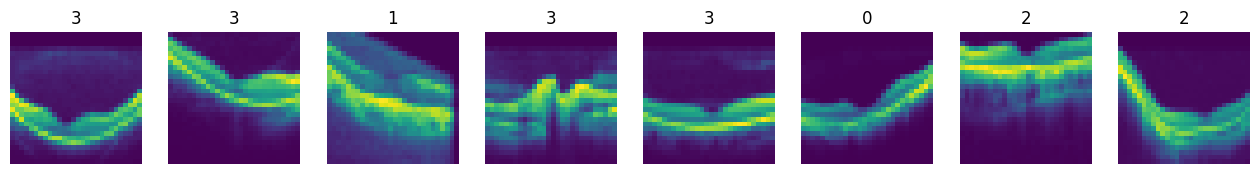

In [13]:
import torchvision.transforms as transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


my_dataset_root = "/mnt/c/Users/Sean/Downloads/OCT_DATASET_DO_NOT_SHARE_WITH_ANYONE_split"
im_size = 28
crop_size = 5

transform_train = transforms.Compose(
    [
        # transforms.RandomCrop(im_size, padding=4),
        transforms.Lambda(lambda img: img.convert("L")),
        transforms.Resize((im_size + 2 * crop_size, im_size + 2 * crop_size)),
        transforms.Lambda(
            lambda img: img.crop((crop_size, crop_size, img.width - crop_size, img.height - crop_size))
        ),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    # transforms.Normalize(mean=[0.11,0.11,0.11], std=[0.18,0.18,0.18])
        # transforms.Normalize(
        # convert to [0,1]
        transforms.Lambda(lambda img: img / np.max(img.numpy())),
    ]
)

transform_test = transforms.Compose(
    [
        transforms.Lambda(lambda img: img.convert("L")),
        transforms.Resize((im_size, im_size)),
        transforms.ToTensor(),
        # transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
        # convert to [0,1]
        transforms.Lambda(lambda img: img / np.max(img.numpy())),
    ]
)

# Visualize a few images
batch_size = 8
# Define the training, validation, and test datasets
train_dataset = ImageFolder(root=my_dataset_root + '/train', transform=transform_train)
val_dataset = ImageFolder(root=my_dataset_root + '/val', transform=transform_test)
test_dataset = ImageFolder(root=my_dataset_root + '/test', transform=transform_test)

# Create data loaders for each dataset
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)
data_iter = iter(train_loader)
for i in range(1):
    images, scalars = next(data_iter)
    image_array = images.numpy()
    scalar_array = scalars.numpy()

    # visualize batch on one row
    fig, axes = plt.subplots(1, batch_size, figsize=(16, 4))
    for i in range(batch_size):
        axes[i].imshow(image_array[i].transpose(1, 2, 0))
        axes[i].set_title(scalar_array[i])
        axes[i].axis("off")
    plt.show()


In [14]:
# Initialize the model, loss function, and optimizer
model = ViT(image_size=28, patch_size=7, num_classes=4, channels=1,
            dim=64, depth=6, heads=8, mlp_dim=128).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')


AttributeError: 'NoneType' object has no attribute 'size'